## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [1]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

%matplotlib inline

In [2]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


def plot_images(images, cls_true, cls_pred=None):
    """
    Adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/
    """
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')

        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

100%|██████████| 170M/170M [00:05<00:00, 29.2MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_ratio

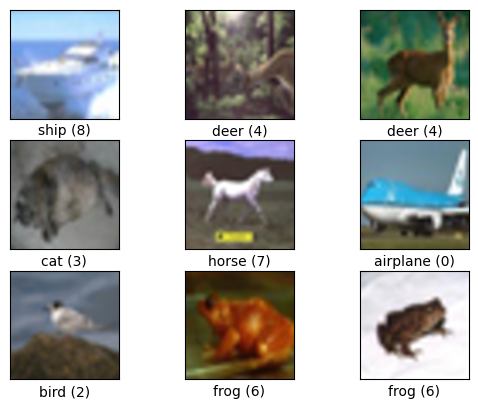

In [3]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed=1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms for validation (no augmentation)
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # Define the transform for training (and data augmentation)

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images if requested
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = next(data_iter)
        # Unnormalize the images for display
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        unnorm_images = [unnormalize(img, mean, std) for img in images]
        X = torch.stack(unnorm_images).numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

def unnormalize(img, mean, std):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return img

trainloader, valloader = get_train_valid_loader()

# Convolutional Neural Network Architecture

Let's first talk about the overall architecture of a CNN and how each dimension evolves after each layer, we'll take as example the first and famous CNN LeNet5 :
<figure align="center">
  <img src="https://doimages.nyc3.cdn.digitaloceanspaces.com/010AI-ML/content/images/2021/10/image-17.png" alt="LeNet5 Architecture" width="600">
  <figcaption>Image credit: <a href="https://en.wikipedia.org">Wikipedia</a></figcaption>
</figure>

For that, we will have some quick questions to see if you understand what happens during training/inference:

### 1. First Layer Convolution

If we consider the input of LeNet5 to be CIFAR-10, what would be the shape of the parameters of the first convolutional layer (stride = 1)?

- **A.** `torch.Size([6, 1, 5, 5])`
- **B.** `torch.Size([6, 3, 3, 3])`
- **C.** `torch.Size([6, 1, 5, 5])`
- **D.** `torch.Size([6, 3, 5, 5])`

D : 6 filters, 3 layers (R,G,B) and W,H = 5

---

### 2. Subsampling Window

What is the shape of the subsampling window (stride = 2) for the second layer (between C1 and C2), and does this shape remain invariant regardless of the subsampling method (e.g., Avg pooling or Max pooling)?

- **A.** `2x2, yes it does`
- **B.** `3x3, no it doesn't`
- **C.** `2x2, no it doesn't`
- **D.** `yes, it does`

F = W1 - S*(W2-1) + 2*P (W1= 28, W2=14, S=2, P=0)
F = 2
In our case it would not change, however it can change thanks to zero padding associated with subsampling which is not happening in pooling.

---

### 3. Backpropagation for Convolutional Filters

Do the filters in the convolutional layers also benefit from backpropagation?

Yes, the filters are what is updated to find the low to high level features during learning.

---

### 4. Role of the Fully-Connected Layer

Explain in your own words why it is necessary to have a fully-connected layer in the architecture.
A fully-connected layer is necessary to take into account each element of the precedent layer. Therefore it is not necessary to have a dense layer at the beginning as the full image has some not so interesting places. However, as we progress into the layers, the more the features appears. Therefore at the end of a Neural Network it is interesting to put a dense layer, to classify by taking into account all the learned features.

---

If you had any struggle to answer one of theses questions, feel free to ask a TA about intuition or hints about the solution.

# Build your own Convolutional Neural Network Architecture

## Different ways to improve the accuracy of your network :
- Change the number of convolutions and layers (you can take inspiration from internet as you as you cite the architecture)
- Change the optmizer / its hyperparameters
- Add new types of layers
- Do some data augmentation in the get_train_valid_loader function (flipped, cropped, uncentered images) cf. https://pytorch.org/vision/stable/transforms.html


In [13]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        # Implementation of a CNN : (Conv=>ReLU=>Conv=>ReLU=>MaxPool) x3 => (FC => Relu) x2 => FC

        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True), # adding inplace=true (and not false as default) change the actual tensor so save memory
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.block_2 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),  # 128 channels due the conv  layers, and 4x4 features due to the 3 MaxPool (32x32 / 2**3 = 4)
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 10)
        )
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        x = self.block_1(x)
        x = x.view(x.size(0), -1)
        x = self.block_2(x)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        return x

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [15]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # We choose the basic Adam optimizer

epochs = 1
steps = 0
running_loss = 0
print_every = 20
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):

        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        #                                                                              #
        ################################################################################
        output = net(images)

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        loss = criterion(output, labels)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update the parameters
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################

        running_loss += loss.item()

        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            for ii, (images, labels) in enumerate(valloader):

                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                output = net.predict(images) # get the output with the new weights
                predicted = torch.argmax(output, dim=1)
                accuracy += (predicted == labels).sum().item() / labels.size(0)
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test accuracy: {:.4f}..".format(accuracy/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()

/tmp/ipython-input-385/3394762393.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(logits)


Epoch: 1/1.. Loss: 2.2974.. Test accuracy: 0.1379.. 0.2255 s/batch
Epoch: 1/1.. Loss: 2.2364.. Test accuracy: 0.2176.. 0.2133 s/batch
Epoch: 1/1.. Loss: 2.0645.. Test accuracy: 0.2752.. 0.2011 s/batch
Epoch: 1/1.. Loss: 1.9055.. Test accuracy: 0.3076.. 0.2401 s/batch
Epoch: 1/1.. Loss: 1.8243.. Test accuracy: 0.2859.. 0.2002 s/batch
Epoch: 1/1.. Loss: 1.8359.. Test accuracy: 0.3258.. 0.2471 s/batch
Epoch: 1/1.. Loss: 1.7701.. Test accuracy: 0.3365.. 0.1989 s/batch
Epoch: 1/1.. Loss: 1.7423.. Test accuracy: 0.3217.. 0.2507 s/batch
Epoch: 1/1.. Loss: 1.7032.. Test accuracy: 0.3754.. 0.2014 s/batch
Epoch: 1/1.. Loss: 1.6375.. Test accuracy: 0.3801.. 0.2418 s/batch
Epoch: 1/1.. Loss: 1.6216.. Test accuracy: 0.3705.. 0.2041 s/batch
Epoch: 1/1.. Loss: 1.6022.. Test accuracy: 0.3928.. 0.2141 s/batch
Epoch: 1/1.. Loss: 1.6241.. Test accuracy: 0.4311.. 0.2016 s/batch
Epoch: 1/1.. Loss: 1.5574.. Test accuracy: 0.4156.. 0.2097 s/batch
Epoch: 1/1.. Loss: 1.5005.. Test accuracy: 0.4133.. 0.2064 s/b

Save best trained model.

In [16]:
## You should be familiar with how to save a pytorch model (Make sure to save the model in your Drive)
torch.save(net.state_dict(), 'CNN_exercise.pth')


# Some visualisations and Interpretation questions
This code allows us to look at the filters of the first layer of convolution :

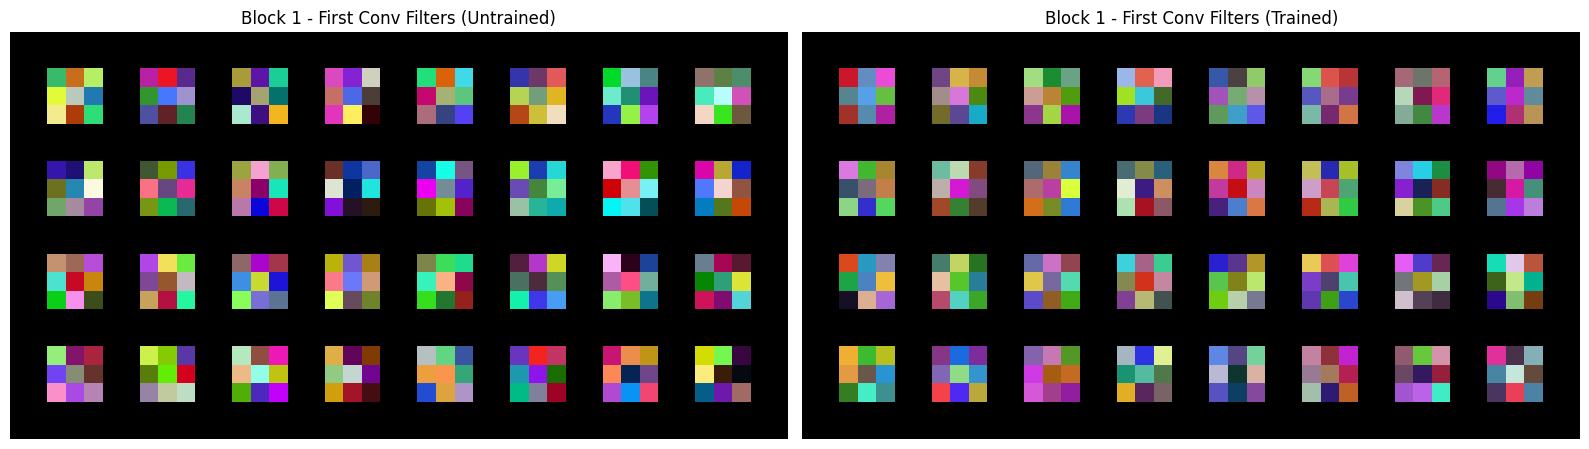

In [25]:
def visualize_filters(layer, title='Filters'):
    filters = layer.weight.data.clone().cpu()
    filters = (filters - filters.min()) / (filters.max() - filters.min())
    grid = vutils.make_grid(filters, nrow=8, padding=2)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = ConvNet() # Untrained model

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Untrained filters ---
# "features[0]" is your first convolutionnal layer, you might have to change it to conv1 if it was the name you gave it to
filters_untrained = model.block_1[0].weight.data.clone().cpu()
filters_untrained = (filters_untrained - filters_untrained.min()) / (filters_untrained.max() - filters_untrained.min())
grid_untrained = vutils.make_grid(filters_untrained, nrow=8, padding=2)
axes[0].imshow(grid_untrained.permute(1, 2, 0))
axes[0].set_title("Block 1 - First Conv Filters (Untrained)")
axes[0].axis("off")

# --- Trained filters ---
# Same thing here
filters_trained = net.block_1[0].weight.data.clone().cpu()
filters_trained = (filters_trained - filters_trained.min()) / (filters_trained.max() - filters_trained.min())
grid_trained = vutils.make_grid(filters_trained, nrow=8, padding=2)
axes[1].imshow(grid_trained.permute(1, 2, 0))
axes[1].set_title("Block 1 - First Conv Filters (Trained)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

#### What do you notice about the filters after the training ? Try to fin an interpretation about it.

The filters changed, meaning they have learned that to classify those categories you need to detect low level features which is what do these filters.


### Activation maps
This code snippet uses a forward hook to capture the output of the first convolutional layer of a CNN when a sample image is passed through it. The resulting activation maps show how each filter in the layer responds to different regions or features in the image.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


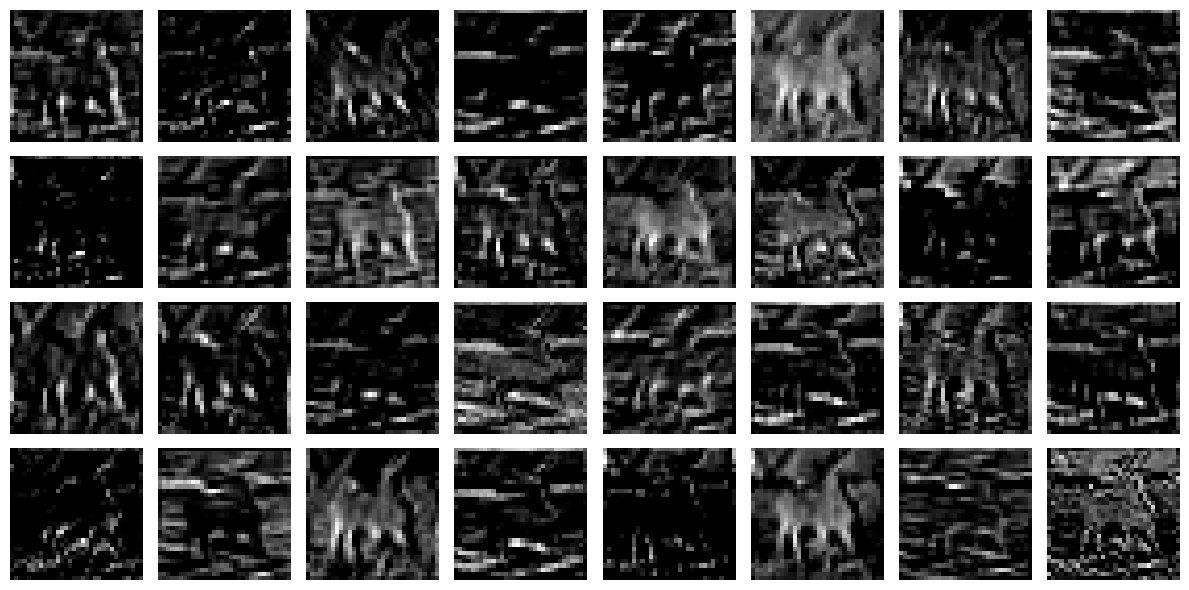

In [27]:
def get_activation(model, layer, x):
    activation = {}
    def hook_fn(module, input, output):
        activation['output'] = output.detach().cpu()
    hook = layer.register_forward_hook(hook_fn)
    model(x)
    hook.remove()
    return activation['output']

data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_img = sample_images[0].unsqueeze(0)

# Get the feature maps after the first convolution (for example)
activation = get_activation(net, net.block_1[0], sample_img)

# Visualize a few feature maps in RGB:
def plot_feature_maps(feature_maps, n_cols=8):
    n_features = feature_maps.shape[1]
    n_rows = (n_features + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i + 1)
        # Extract the i-th feature map from the first (and only) sample in the batch
        act = feature_maps[0, i, :, :]
        # Normalize the activation map to [0, 1]
        act_norm = (act - act.min()) / (act.max() - act.min() + 1e-8)
        # Repeat the single channel 3 times to form an RGB image
        act_rgb = act_norm.unsqueeze(0).repeat(3, 1, 1)
        plt.imshow(act_rgb.permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_feature_maps(activation, n_cols=8)

# Play with the index of the chosen sample to notice more patterns and answer the question


### 1. Feature Detection
What specific features do you observe in these activation maps? Do some maps clearly highlight edges, contours, or textures? How might these features relate to the overall structure of the sample (e.g., the outline of a horse)?

The activation maps show low-level features: edge detectors (vertical/horizontal/diagonal), texture patterns, and contrast/brightness variations. Some filters act like Sobel operators highlighting contours and other gives us a differenciation between foreground and background (2nd filter from the left at the bottom line). These generic features are shared across all object classes and combine in deeper layers to detect higher-level structures like animal shapes or vehicle silhouettes.

---

### 2. Effect of Training
Consider how the activations might change after training versus an untrained (random) network. What does this tell you about the learning process?

In an untrained network, filters have random weights, so activation maps look noisy with no clear patterns—they don't capture meaningful structure. After training, filters learn specialized detectors (one for horizontal edges, another for curves) optimized via backpropagation to minimize classification loss. This shows learning is about discovering which low-level patterns best discriminate between classes.